# Simulation of Belvarafenib and Cobimetinib inhibition in NRAS<sup>Q61</sup> melanoma cells with CRAF feedback using the MARM2 model

Here you can simulate the time-course respose of NRAS<sup>Q61</sup> cells under different doses of RAF (belvarafenib) and MEK inhibitors (cobimetinib) and  CRAF feedback. 


**Note**: this code performs the simulation for a single condition and visualizes the time-course response. Use the Jupyter Notebook *Simulate_Belva_Cobi_SS_NRAS_Q61_w_CRAF_feedback.ipynb* to generate simulation results for multiple conditions (e.g. multiple dose combinations). 



## Import of libraries
Importing libraries necessary to run MARM2 model simulations.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import time
# starts time to seee total computational costs
start_time = time.time()

Changes to main file directory. This works provided the "main_dir" has the correct directory name and the cwd starts within the main file directory. This might require tweaking under some high performance computing setups.

In [2]:
main_dir = "MARM2_Andrew_8_24"
for i in Path().resolve().parents:
    if i.parts[-1] == main_dir:
        os.chdir(i)

Importing the MARM2 PySB model and the simulator.  

In [3]:
from pysb.simulator import ScipyOdeSimulator
from pysb.core import as_complex_pattern
from pysb.bng import generate_equations

from scripts.models.MARM2_NRAS_Q61_No_RTK import model
from scripts.functions.pysb_helper_functions import equilibrate, get_species_index

## User-defined experimental setup
In this section you can alter the setup of the experiment simulated by MARM2. First, you need to define the experimental setup of the pre-treatment phase and of the subsequent inhibitor dose phase. The variables needed for the pre-treatment phase are:

<b>Pretreatment_time (h)</b>: defines the duration of the pre-treatment phase.
    
For the treatment phase, you need to set the running time of simulation after inhibitor dose. This is done with the following variables:

<b>Simulation_time (h)</b>: define the simulation time after inhibitor dose. 

<b>N_time_points</b>: define the number of time points returned by each model simulation. 

1. **Pretreatment duration** in hours.

In [4]:
t_pretrt = 24

2. **Simulation time** in hours.

In [5]:
t_trt = 8

3. **Parameter set** selects which of the 50 best-fit parameter sets to use for the simulation. Set 0 is the best fit and 49 the worst.

In [6]:
param_set_index = 13

4. **N_time_points** defineds the number of time points returned by each individual model simulation

In [7]:
N_time_points = 97

## Generate model equations
PySB runs BioNetGen to generate the reaction network

In [8]:
generate_equations(model)

## Parameter set preparation

Loads and prepares the parameter sets described in Fr&ouml;hlich et al [1].   

In [9]:
param_sets = pd.read_csv(Path('data/Model_parameters/RTKERK_pRAF_EGF_EGFR_MEKi_PRAFi_RAFi.csv'), index_col=0)
# finds the parameters of the .csv file that correspond to Cobimetinib and Vemurafenib and maps them to MEKi and RAFi (respectively)
rename_dict = {}
for i in param_sets.columns:
    if "Cobimetinib" in i or "Vemurafenib" in i:
        rename_dict[i] = i.replace("Cobimetinib","MEKi").replace("Vemurafenib","RAFi")
param_sets = param_sets.rename(columns = rename_dict)

# finds the parameters which are stored in .csv file but not in the model and removes them
csv_spec_params = set(param_sets.columns)-(set(param_sets.columns)&set([i.name for i in model.parameters]))
param_sets = param_sets.drop(csv_spec_params, axis=1)

# Reduces GTP hydrolysis to align with expected GTPase activity of NRASQ61mut
param_sets["catalyze_NF1_RAS_gdp_kcatr"] = param_sets["catalyze_NF1_RAS_gdp_kcatr"] / 10
# Makes dimers less favorable
param_sets["ep_RAF_RAF_mod_RASgtp_double_ddG"] = param_sets["ep_RAF_RAF_mod_RASgtp_double_ddG"]/5
# Removes preference against second inhibitor binding to model type 2 pan RAF inhibitor (Belvarafenib)
param_sets["ep_RAF_RAF_mod_RAFi_double_ddG"] = 0
# Remove negative feedback CRAF
#param_sets['ep_RAF_RAF_mod_pRAF_ddG'] = 0 


params = param_sets.iloc[param_set_index].to_dict()

In [10]:
params['RAFi_0'] = 0.0
params['MEKi_0'] = 0.0

## Initial equilibrium
First we run the model from its baseline initial conditions until equilibrium is reached. For example protein synthesis/degradation, phosphorylation/dephosphorylation, and drug binding/unbinding all need to reach steady state to match the state of the cells in the experimental setup. There may be some time without visible progress as behind the scenes PySB runs BioNetGen to generate the reaction network and Cython to compile the resulting differential equations into efficient executable code.

In [11]:
sim = ScipyOdeSimulator(model,param_values=params) 
df_eq = equilibrate(sim, None)

    at t=100   ... 881/881 species converged


Now that the model has been simulated once and the actual molecular species have been enumerated, we can find the exact species numbers for the inhibitors. These are needed so that their concentrations can be overridden in the model state for subsequent simulations.

In [12]:
RAFi_index = get_species_index(model, model.monomers.RAFi(raf=None)**model.compartments.CP)
MEKi_index = get_species_index(model, model.monomers.MEKi(mek=None)**model.compartments.CP)

## Inhibitor pre-treatment

We take the final state of the equilibration simulation and use it as the initial state of this new simulation, overriding the RAFi and MEKi concentrations with the user-selected values.

In [13]:
initials_pre = df_eq.iloc[-1, :len(model.species)].copy()
initials_pre[RAFi_index] = 0.0
initials_pre[MEKi_index] = 0.0

#fixed time pre-treatment simulation
tspan_pretrt = np.linspace(0, t_pretrt, N_time_points)
df_pre=sim.run(tspan=tspan_pretrt, initials=initials_pre.to_list()).dataframe

In case the previous simulation was run to steady state, we want to retain only the first t_pretrt hours of pre-treatment plus the state at final equilibrium. So we cut the time series down using a Pandas slice operation and adjust the remaining time values to begin at -pre_time_max.

In [14]:
if (len(df_pre.loc[:t_pretrt])<len(df_pre)):
   df_pre_tmp = df_pre.loc[:t_pretrt]
   df_pre_tmp.iloc[-1] = df_pre.iloc[-1]
   df_pre= df_pre_tmp
df_pre['time'] = df_pre.index
df_pre['time'] = df_pre['time']-t_pretrt
df_pre['time'].iloc[-1] = 0
df_pre.reset_index(drop=True, inplace=True)
df_pre.set_index('time', inplace=True)

## Inhibitor treatment

We run another simulation starting from the final state of the pre-treatment simulation, overriding the MEKi and PRAFi concentrations with the user-selected values. This is a fixed-time simulation rather than the steady-state equilibration used in the previous simulations.

In [15]:
RAFi_concentration = 0
MEKi_concentration = 0.5

In [16]:
tspan_trt = np.linspace(0, t_trt, N_time_points)
initials_trt = df_pre.iloc[-1, :len(model.species)].copy()
initials_trt[RAFi_index] = RAFi_concentration
initials_trt[MEKi_index] = MEKi_concentration
#initials_trt[EGF_index] = EGF_concentration / model.parameters['m_Da_EGF'].get_value()
df_trt = sim.run(tspan=tspan_trt, initials=initials_trt.to_list()).dataframe

Concatenate the dataframes holding the pre-treatment and treatment simulation trajectories, keeping only the columns corresponding to model observables. Also filter out "noise" (insignificant concentration fluctuations caused by numerical integration tolerance issues).

In [17]:
obs = pd.concat([df_pre, df_trt.iloc[1:]])[df_pre.keys()[len(model.species):]]
obs.loc[:, (obs < 1e-10).all()] = 0

## Write time courses to CSV file

Append information on parameter sets used in this simulation and save the time course trajectories to file.

In [18]:
settings = {
    'Cell_line': 'A375_sim',
    'Parameter_set': param_set_index,
    'Drug A': 'Vemurafenib',
    'Drug B': 'Cobimetinib',
    'Concentration A (uM)': RAFi_concentration,
    'Concentration B (uM)': MEKi_concentration,
    'Time A (h)': t_pretrt,
    'Time B (h)': t_pretrt,
}
obs_out = obs.copy()
for column, value in settings.items():
     obs_out[column] = value
obs_out.to_csv(Path('data/Temporal_response_trajectories/trajectories_single_run_Q61_w_CRAF.csv'))

## Plot time courses

Plot time-course trajectories of meaninfgul model species. The pre-treatment timescale is collapsed on a smallar interval for display purposes.

In [19]:
pre_time_scale = 0.5
obs_plot = obs.reset_index()
time_scale_factor = pre_time_scale / -obs_plot['time'].iloc[0]
obs_plot.loc[obs_plot['time'] < 0, 'time'] *= time_scale_factor
obs_plot = obs_plot.reindex(sorted(obs_plot.columns), axis=1)

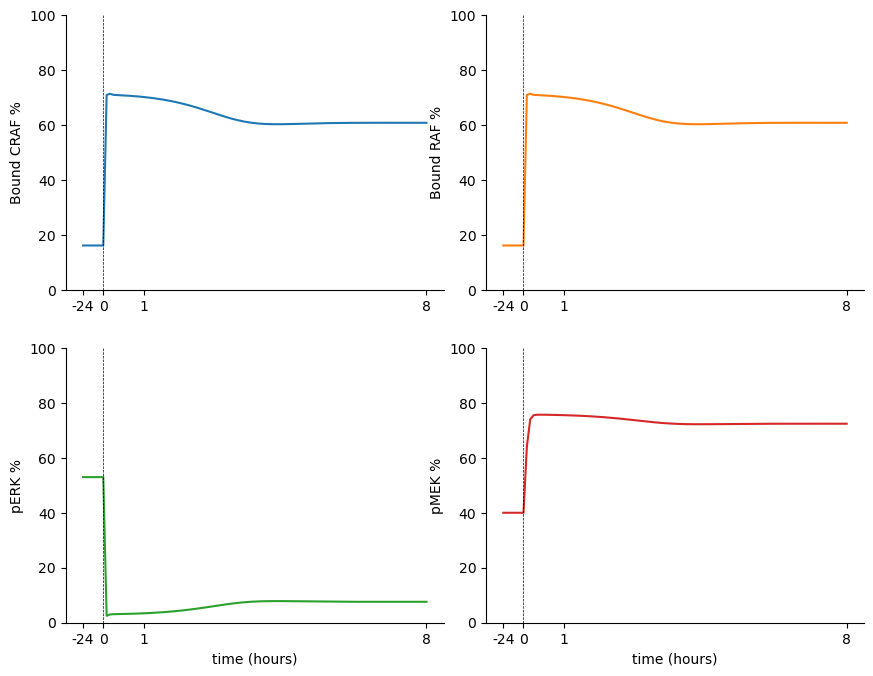

In [20]:
obs_melted = obs_plot.melt(id_vars='time')
obs_array = np.array(["Bound_CRAF_percent","Bound_BRAF_percent","Bound_RAF_percent","pERK_percent","pMEK_percent"])
upper_bound = {"Bound_CRAF_percent":100,"Bound_BRAF_percent":100,"Bound_RAF_percent":100,"pERK_percent":100,"pMEK_percent":100}
selected_obs_melted = obs_melted[np.isin(obs_melted["variable"],obs_array)]
g = sns.FacetGrid(
    selected_obs_melted, col='variable', hue='variable', col_wrap=2,
    sharex=False, sharey=False, height=3.5, aspect=1.25
)
g.map(plt.plot, 'time', 'value')
for ax_ind in range(len(g.axes)):
    _, ymax = g.axes[ax_ind].get_ylim()
    upper_bound_val = upper_bound[g.axes[ax_ind].get_title().replace("variable = ",'')]
    g.axes[ax_ind].set_ylim(ymin=0, ymax=upper_bound_val)
    g.axes[ax_ind].set_xticks([-pre_time_scale, 0, 1, t_trt])
    g.axes[ax_ind].set_xticklabels(['-'+str(t_pretrt), '0', '1', str(t_trt)])
    g.axes[ax_ind].axvline(0, color='k', linewidth=0.5, linestyle='--')
    g.axes[ax_ind].set_ylabel(g.axes[ax_ind].get_title().replace("variable = ",'').replace("_"," ").replace("percent","%"))
    g.axes[ax_ind].set_title("")
    
g.set_xlabels('time (hours)')
#g.set_ylabels('%')
g.savefig(Path('figures/Temporal_response_trajectories/NRAS_Q61/NRAS_Q61_w_CRAF.svg'),format = 'svg')

## References

[1] Fröhlich, F., Gerosa, L., Muhlich, J., & Sorger, P. K. (2023). Mechanistic model of MAPK signaling reveals how allostery and rewiring contribute to drug resistance. Molecular Systems Biology, 19(2), e10988. doi:10.15252/msb.202210988

# Session Info and Runtime

In [21]:
print("Elapsed Time = "+str(time.time() - start_time) + " seconds")
!conda env export --name quant_bio

Elapsed Time = 29.917582750320435 seconds
name: quant_bio
channels:
  - conda-forge
  - alubbock
  - defaults
dependencies:
  - anyio=4.2.0=py311hca03da5_0
  - appnope=0.1.2=py311hca03da5_1001
  - argon2-cffi=21.3.0=pyhd3eb1b0_0
  - argon2-cffi-bindings=21.2.0=py311h80987f9_0
  - asttokens=2.0.5=pyhd3eb1b0_0
  - async-lru=2.0.4=py311hca03da5_0
  - attrs=23.1.0=py311hca03da5_0
  - babel=2.11.0=py311hca03da5_0
  - beautifulsoup4=4.12.2=py311hca03da5_0
  - bionetgen=2.9.1=0
  - blas=1.0=openblas
  - bleach=4.1.0=pyhd3eb1b0_0
  - bottleneck=1.3.7=py311hb9f6ed7_0
  - brotli=1.0.9=h1a28f6b_7
  - brotli-bin=1.0.9=h1a28f6b_7
  - brotli-python=1.0.9=py311h313beb8_7
  - bzip2=1.0.8=h80987f9_5
  - ca-certificates=2024.2.2=hf0a4a13_0
  - certifi=2024.2.2=py311hca03da5_0
  - cffi=1.16.0=py311h80987f9_0
  - charset-normalizer=2.0.4=pyhd3eb1b0_0
  - comm=0.2.1=py311hca03da5_0
  - contourpy=1.2.0=py311h48ca7d4_0
  - cycler=0.11.0=pyhd3eb1b0_0
  - cython=3.0.8=py311h80987f9_0
  - debugpy=1.6.7=py311h31